In [43]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D

In [44]:

plate_cascade = cv2.CascadeClassifier('indian_license_plate.xml')


In [45]:
def detect_plate(img, text=''): 
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.2, minNeighbors = 7) 
    for (x,y,w,h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :] 
        plate = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img, (x+2,y), (x+w-3, y+h-5), (51,181,155), 3) 
    if text!='':
        plate_img = cv2.putText(plate_img, text, (x-w//2,y-h//2), 
                                cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.5, (51,181,155), 1, cv2.LINE_AA)
        
    return plate_img, plate 

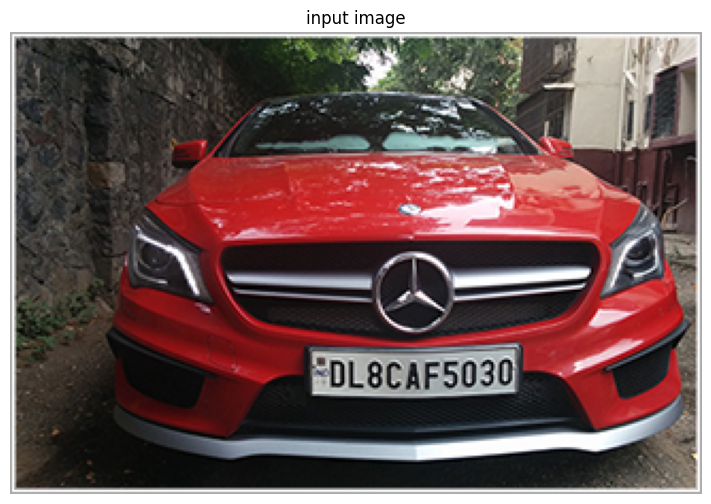

In [46]:

def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

img = cv2.imread('car.jpg')
display(img, 'input image')

In [47]:

output_img, plate = detect_plate(img)

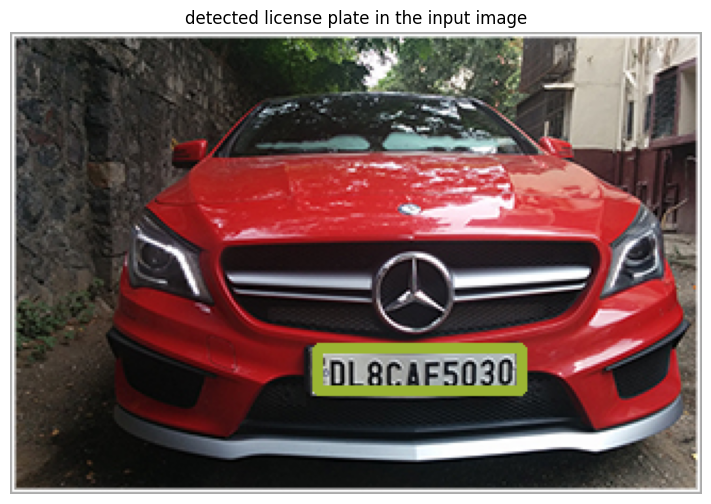

In [48]:
display(output_img, 'detected license plate in the input image')            

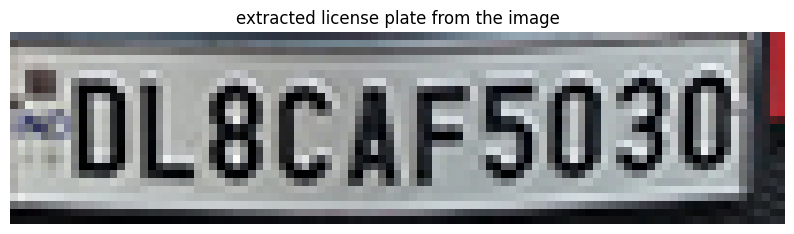

In [49]:
display(plate, 'extracted license plate from the image')

In [50]:

def find_contours(dimensions, img) :

    
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) 

            char_copy = np.zeros((44,24))
            
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

        
            char = cv2.subtract(255, char)

            
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) 
            
            
    plt.show()
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])
    img_res = np.array(img_res_copy)

    return img_res

In [51]:

def segment_characters(image) :

    
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

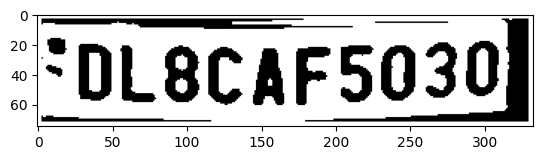

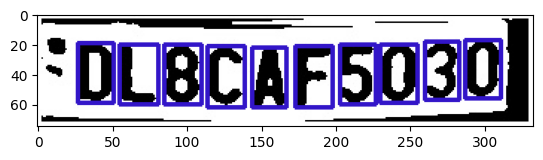

In [52]:

char = segment_characters(plate)

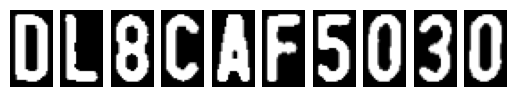

In [53]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

### Model for characters

In [54]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    'train',  
    target_size=(28, 28),
    batch_size=32,  
    class_mode='sparse')


validation_generator = train_datagen.flow_from_directory(
    'val',
    target_size=(28, 28),  
    batch_size=32,
    class_mode='sparse')


Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [55]:

def f1score(y, y_pred):
  return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
  return tf.py_function(f1score, (y, y_pred), tf.double)

In [56]:
import tensorflow.keras.backend as K

K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=[custom_f1score])

In [57]:



model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        23248     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        65600     
                                                                 
 max_pooling2d (MaxPooling2  (None, 7, 7, 64)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                        

In [58]:
class stop_training_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_custom_f1score') > 0.99):
      self.model.stop_training = True

In [59]:
batch_size = 32
callbacks = [stop_training_callback()]
model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs =15 , verbose=1, callbacks=callbacks)

Epoch 1/15
27/27 [==============================] - 29s 1s/step - loss: 3.5851 - custom_f1score: 0.0289 - val_loss: 3.4944 - val_custom_f1score: 0.0357
Epoch 2/15
27/27 [==============================] - 28s 1s/step - loss: 3.2883 - custom_f1score: 0.0891 - val_loss: 3.0566 - val_custom_f1score: 0.1310
Epoch 3/15
27/27 [==============================] - 26s 946ms/step - loss: 2.9110 - custom_f1score: 0.1644 - val_loss: 2.6625 - val_custom_f1score: 0.2083
Epoch 4/15
27/27 [==============================] - 25s 927ms/step - loss: 2.6388 - custom_f1score: 0.2118 - val_loss: 2.4541 - val_custom_f1score: 0.2440
Epoch 5/15
27/27 [==============================] - 25s 931ms/step - loss: 2.2459 - custom_f1score: 0.3113 - val_loss: 2.3148 - val_custom_f1score: 0.3318
Epoch 6/15
27/27 [==============================] - 25s 923ms/step - loss: 2.0848 - custom_f1score: 0.3356 - val_loss: 1.9645 - val_custom_f1score: 0.3810
Epoch 7/15
27/27 [==============================] - 25s 936ms/step - loss: 1

In [60]:
# Predicting the output
def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = np.argmax(model.predict(img), axis=-1)[0] #predicting the class
        character = dic[y_] #
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

1/1 [==============================] - 0s 30ms/step
GJ6CAF5G3G


1/1 [==============================] - 0s 31ms/step


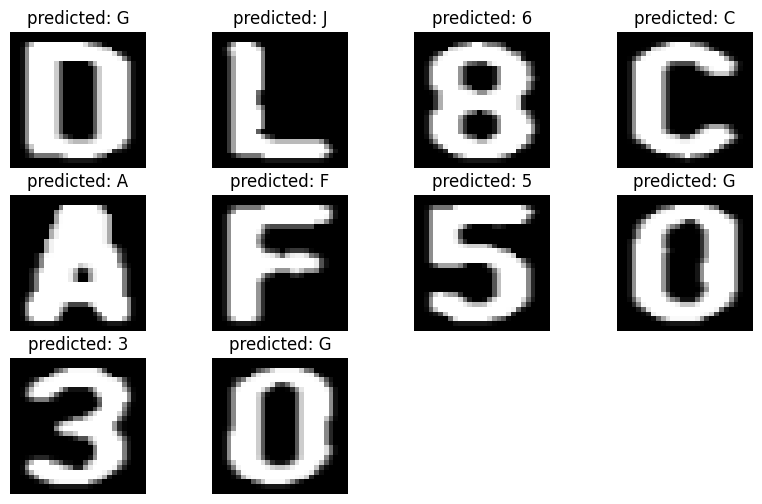

In [61]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

In [62]:
plate_number = show_results()


1/1 [==============================] - 0s 33ms/step
